In [1]:
import re
import os
import glob
from bs4 import BeautifulSoup
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

def review_to_words(review):
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words


import pickle

cache_dir = os.path.join("./cache", "fake_news_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train,data_valid, data_test, labels_train, labels_valid, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(data) for data in data_train]
        words_valid = [review_to_words(data) for data in data_valid]
        words_test = [review_to_words(data) for data in data_test]
        
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_valid = words_valid, words_test=words_test,
                              labels_train=labels_train, labels_valid = labels_valid, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_valid, words_test, labels_train, labels_valid, labels_test = (cache_data['words_train'], cache_data['words_valid'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_valid'], cache_data['labels_test'])
    
    return words_train, words_valid, words_test, labels_train, labels_valid, labels_test


import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_valid, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()
        features_valid =  vectorizer.fit_transform(words_valid).toarray()
        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_valid=features_valid, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_valid, features_test, vocabulary = (cache_data['features_train'], cache_data['features_valid'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_valid, features_test, vocabulary

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def mapLablesToNumbers(labels):
    y_label_dict = {"pants-fire" : 0, "FALSE" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "TRUE" : 5, "false": 1, "true": 5}
    mapped_data = labels.apply(lambda x: y_label_dict[x])
    return mapped_data
    

In [3]:
import pandas as pd
columns = ["file","result","news","type","person","desingation","state","party","PF","F","BT","MT","KT","context"]
train_complete_data = pd.read_csv(os.path.join("./data", "train.tsv"), sep = "\t", names = columns)
valid_complete_data = pd.read_csv(os.path.join("./data", "valid.tsv"), sep='\t', names = columns)
test_complete_data = pd.read_csv(os.path.join("./data", "test.tsv"), sep='\t', names = columns)

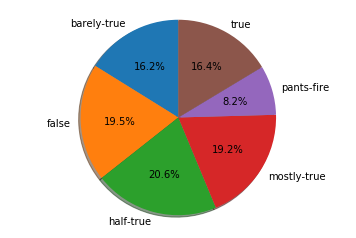

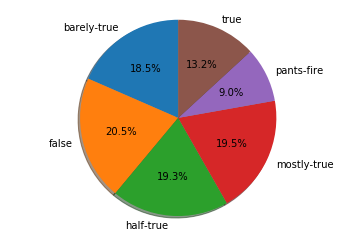

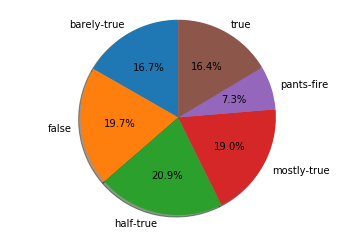

result
barely-true    1654
false          1995
half-true      2114
mostly-true    1962
pants-fire      839
true           1676
Name: file, dtype: int64 train count
result
barely-true    237
false          263
half-true      248
mostly-true    251
pants-fire     116
true           169
Name: file, dtype: int64 valid count
result
barely-true    212
false          249
half-true      265
mostly-true    241
pants-fire      92
true           208
Name: file, dtype: int64 test count


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

train_count = train_complete_data.groupby(["result"]).count()["file"]
train_labels = []
train_sizes = []
for index, value in train_count.items():
    train_labels.append(index)
    train_sizes.append(value)

fig1, ax1 = plt.subplots()
ax1.pie(train_sizes, labels=train_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


valid_count = valid_complete_data.groupby(["result"]).count()["file"]
valid_labels = []
valid_sizes = []
for index, value in valid_count.items():
    valid_labels.append(index)
    valid_sizes.append(value)

fig2, ax2 = plt.subplots()
ax2.pie(valid_sizes, labels=valid_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



test_count = test_complete_data.groupby(["result"]).count()["file"]
test_labels = []
test_sizes = []
for index, value in test_count.items():
    test_labels.append(index)
    test_sizes.append(value)

fig3, ax3 = plt.subplots()
ax3.pie(test_sizes, labels=test_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

print(train_count, "train count")
print(valid_count, "valid count")
print(test_count, "test count")

In [12]:

train_data = train_complete_data["news"]
train_label = mapLablesToNumbers(train_complete_data["result"])
valid_data = valid_complete_data["news"]
valid_label = mapLablesToNumbers(valid_complete_data["result"])
test_data = test_complete_data["news"]
test_label = mapLablesToNumbers(test_complete_data["result"])


print(len(train_data), "train data - Before")
print(len(train_label), "train label - Before")

print(len(valid_data), "valid data - Before")
print(len(valid_label), "valid label - Before")

print(len(test_data), "test data - Before")
print(len(test_label), "test label - Before")

train_data = pd.concat([train_data,valid_data], axis = 0)
train_label = pd.concat([train_label, valid_label], axis = 0)

print(len(train_data), " Train data  - After")
print(len(train_label), "Train label - After")
print(len(valid_data), "valid data - After")
print(len(valid_label), "valid label - After")

10240 train data - Before
10240 train label - Before
1284 valid data - Before
1284 valid label - Before
1267 test data - Before
1267 test label - Before
11524  Train data  - After
11524 Train label - After
1284 valid data - After
1284 valid label - After


In [28]:
train_data, valid_data, test_data, train_label, valid_label, test_label = preprocess_data(train_data, valid_data, test_data, train_label, valid_label, test_label)
train_data, valid_data, test_data, vocabulary = extract_BoW_features(train_data, valid_data, test_data)
valid_data = train_data[10240:]
train_data = train_data[:10240]
valid_label = train_label[10240:]
train_label = train_label[:10240]

print(len(train_data), " Train data  - After")
print(len(valid_data), "valid data - After")
print(len(valid_label), "valid label - After")
print(len(train_label), "Train label - After")

train_data, valid_data, test_data = (pd.DataFrame(train_data), pd.DataFrame(valid_data), pd.DataFrame(test_data))
#train_label, valid_label, test_label = (pd.DataFrame(train_label[:].values), pd.DataFrame(valid_label[:].values), pd.DataFrame(test_label[:].values))


Read preprocessed data from cache file: preprocessed_data.pkl
Read features from cache file: bow_features.pkl
10240  Train data  - After
1284 valid data - After
1284 valid label - After
10240 Train label - After


In [29]:
data_dir = './data/xgboost'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# First, save the test data to test.csv in the data_dir directory. Note that we do not save the associated ground truth
# labels, instead we will use them later to compare with our model output.
print(len(test_data))
pd.DataFrame(test_data).to_csv(os.path.join(data_dir, 'test.csv'), header = False, index = False)
temp_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
# TODO: Save the training and validation data to train.csv and validation.csv in the data_dir directory.
#       Make sure that the files you create are in the correct format.

# Solution:
#
#

pd.concat([valid_label, valid_data], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header = False, index = False)
pd.concat([train_label, train_data], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header = False, index = False)
temp_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
temp_validation = pd.read_csv(os.path.join(data_dir, 'validation.csv'))

# print(len(temp_train), "Train temp")
# print(len(temp_validation), "Validation Temp")
# print(len(temp_test), "Test Temp")
# print(len(valid_label), "valid label - Temp")
# print(len(train_label), "Train label - Temp")
# print(len(test_label), "Test label - Temp")

1267


In [30]:
import sagemaker

session = sagemaker.Session() # Store the current SageMaker session

# S3 prefix (which folder will we use)
prefix = 'fake-xgboost'

# TODO: Upload the test.csv, train.csv and validation.csv files which are contained in data_dir to S3 using sess.upload_data().
test_location = None
val_location = None
train_location = None

# Solution:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [31]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

container = get_image_uri(session.boto_region_name, 'xgboost','0.90-1')
role = get_execution_role()

In [32]:
# TODO: Create a SageMaker estimator using the container location determined in the previous cell.
#       It is recommended that you use a single training instance of type ml.m4.xlarge. It is also
#       recommended that you use 's3://{}/{}/output'.format(session.default_bucket(), prefix) as the
#       output path.

xgb = None

# Solution:
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# TODO: Set the XGBoost hyperparameters in the xgb object. Don't forget that in this case we have a binary
#       label so we should be using the 'binary:logistic' objective.

# Solution:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=4,
                        subsample=0.8,
                        silent=0,
                        objective='multi:softprob',
                        early_stopping_rounds=10,
                        eval_metric = 'mlogloss',
                        num_class = 6,
                        num_round=700)

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

In [ ]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-05-07 02:35:28 Starting - Starting the training job..

In [ ]:
# TODO: Create a transformer object from the trained model. Using an instance count of 1 and an instance type of ml.m4.xlarge
#       should be more than enough.
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

# TODO: Start the transform job. Make sure to specify the content type and the split type of the test data.
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [ ]:
xgb_transformer.wait()

In [ ]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

In [ ]:
!aws s3 cp --recursive $test_location ./temp/

In [ ]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
#predictions = [round(num) for num in predictions.squeeze().values]


print(len(test_label), 'test label')
print(len(test_data), 'test data')
print(len(train_label), 'train label')
print(len(train_data), 'train data')
print(len(valid_label), 'valid label')
print(len(valid_data), 'valid label')

#tempData = pd.read_csv('./temp/test.csv')
#tempData
predictions[0] = predictions[0].str.replace('[', "")
predictions[5] = predictions[5].str.replace(']', "")
predictions = predictions.apply(pd.to_numeric)
predictions = predictions.idxmax(axis=1)


# print(len(test_label))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_label, predictions)